In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
import scipy.interpolate
import utils_LJ7
from utils_LJ7 import LJ7_2

import math
pitorch = torch.Tensor([math.pi])

Shape of trajectory data:(2, 10000)
Shape of diffusion data:(10000, 2, 2)


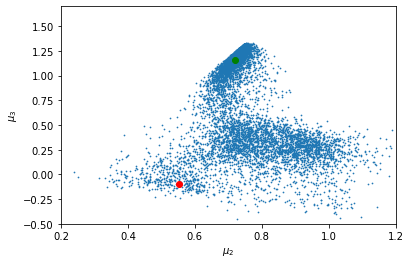

In [4]:
# Load collective varaibles data
data_folder = Path('./LJ7')
fname = data_folder/"LJ7_traj.npz"
inData = np.load(fname)
data = inData["data"]
print(f"Shape of trajectory data:{data.shape}")
N = data.shape[1]
data = torch.tensor(data,dtype=torch.float32)
train_data = torch.cat((data[0,:].reshape(N,1),data[1,:].reshape(N,1)),dim = 1)
train_data.requires_grad_(True)


# Load Diffusions
fname = data_folder/"LJ7_traj_diffusions.npz"
inData = np.load(fname)
diffusions = inData["diffusions"]
print(f"Shape of diffusion data:{diffusions.shape}")
diffusions_phipsi = torch.tensor(diffusions,dtype=torch.float32)

fig = plt.figure() 
plt.scatter(train_data.detach().numpy()[:,0], train_data.detach().numpy()[:,1], s=0.5)
plt.xlabel(r'$\mu_2$')
plt.ylabel(r'$\mu_3$')
plt.xlim([0.2, 1.2])
plt.ylim([-0.5, 1.7])
a = [0.5526,-0.0935]
b = [0.7184,1.1607]
plt.scatter(a[0],a[1],color = 'red')
plt.scatter(b[0],b[1],color = 'green')

In [5]:
import numpy 
input_size = 2
output_size = 1
model = LJ7_2(input_size,10,10,output_size)

In [6]:
size1,size2 = train_data.shape
rhs = torch.zeros(size1,)
train_ds = TensorDataset(train_data,rhs,diffusions_phipsi)
batch_size = int(size1/125)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
loss_fn = nn.L1Loss()
optimizer1 = optim.Adam(model.parameters(), lr=1e-3)
scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[500,1000], gamma=0.5)

beta = 5

In [7]:
for epoch in range(1000):
    for X,y,diffusion_map in train_dl:
        optimizer1.zero_grad()

        chia,chib = utils_LJ7.chiAB(X)
        q_tilde = utils_LJ7.model(X)
        Q = utils_LJ7.q_theta(X,chia,chib,q_tilde)
    
        derivQ = torch.autograd.grad(Q,X,allow_unused=True, retain_graph=True, grad_outputs = torch.ones_like(Q), create_graph=True)
        product = torch.tensor([])
        
        for i in range(batch_size):
            product_new = derivQ[0][i]@diffusion_map[i]@derivQ[0][i].reshape(2,1)
            product = torch.cat((product,product_new.reshape(1,1)), dim = 0)
            
        output = product.reshape(batch_size)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer1.step()
        
    if epoch%25 == 0:
        print('Epoch: {}, Loss : {:.4f}'.format(epoch, loss))
    

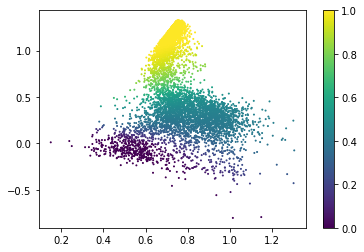

In [9]:
chia,chib = chiAB(train_data)
q_tilde = model(train_data)
Q = q_theta(train_data,chia,chib,q_tilde)
X1 = train_data[:,0]
X2 = train_data[:,1]
plt.scatter(X1.detach().numpy(),X2.detach().numpy(), s=1.0, c=Q.detach().numpy())
plt.colorbar()
plt.show()

In [10]:
# torch.save(model,'LJ7_2hidden_LJ7.pt')

# Compare with FEM result

In [12]:
model = torch.load('./data/LJ7_2hidden_LJ7.pt')
model.eval()

pts = np.loadtxt(data_folder/'LJ7_pts_ABellipses.csv', delimiter=',', dtype=float)
tri = np.loadtxt(data_folder/'LJ7_tri_ABellipses.csv', delimiter=',', dtype=int)
q = np.loadtxt(data_folder/'LJ7_ABellipses_q.csv', delimiter=',', dtype=float)
Fpts = np.loadtxt(data_folder/'LJ7_ABellipses_free.csv', delimiter=',', dtype=float)

pts_tensor = torch.tensor(pts,dtype = torch.float32)
q_fem = torch.tensor(q,dtype = torch.float32)
Fpts_tensor = torch.tensor(Fpts,dtype = torch.float32)

In [13]:
chia,chib = chiAB(pts_tensor)
q_tilde = model(pts_tensor)
Q = q_theta(pts_tensor,chia,chib,q_tilde).detach().numpy().squeeze()

Z_f =np.sum(q*(1-q)*np.exp(-5*Fpts))
mR = q*(1-q)*np.exp(-5*Fpts)/Z_f

diff = np.abs(Q - q)
MAE = np.sum(mR*diff)
RMSE = np.sqrt(np.sum(mR*diff**2))
print('The wMAE of uniform in space when beta = 5 is {}, and wRMSE is {}'.format(MAE,RMSE))

The MAE of uniform in space when beta = 5 is 0.015309374647155571, and RMSE is 0.024340938181320756


# Visual Comparison

In [16]:
from LJ7 import distmesh
from LJ7 import FEM_TPT

In [17]:
pts = np.loadtxt(data_folder/'LJ7_pts_B07.csv', delimiter=',', dtype=float)
tri = np.loadtxt(data_folder/'LJ7_tri_B07.csv', delimiter=',', dtype=int)

In [18]:
def check_inf_nan(arr):
    ind_bad = np.argwhere(np.isnan(arr))
    print(np.size(ind_bad)," points with nan or inf values")
    return ind_bad

In [19]:
nx= 100
ny = 100
x = np.linspace(0.2, 1.2, nx)
y = np.linspace(-0.5, 1.7, ny)
xx, yy = np.meshgrid(x, y)
xxyy = np.hstack((xx.ravel()[:,None],yy.ravel()[:,None]))
data = np.loadtxt(data_folder/'LJ7_TPTdata_B07.csv', delimiter=',', dtype=float)
q = data[:,2]
grid_q = scipy.interpolate.griddata(pts,q,xxyy,method = 'linear')
bad_ind = check_inf_nan(grid_q)
new_grid = np.delete(xxyy,bad_ind[:,0],0)
new_q = np.delete(grid_q,bad_ind[:,0],0)

5768  points with nan or inf values


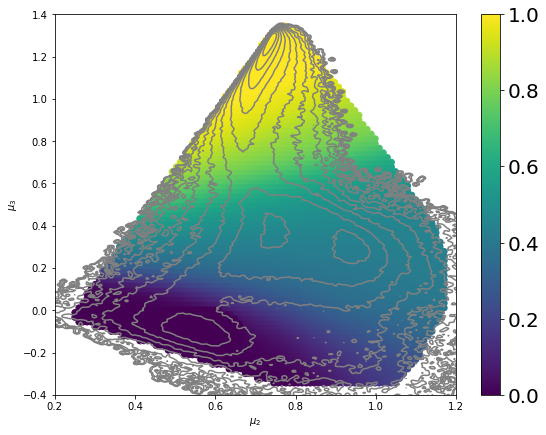

In [20]:
# contour plot for free energy
fname = data_folder/"LJ7_free_energy_grid.npz"
inData = np.load(fname)
free_energy = inData["free_energy"]
nx = inData["nx"]
ny = inData["ny"]
xmin = inData["xmin"]
xmax = inData["xmax"]
ymin = inData["ymin"]
ymax = inData["ymax"]

x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(x, y)
plt.figure()
plt.contour(xx, yy, free_energy, levels=15,colors = 'gray')
plt.xlim([0.2, 1.2])
plt.ylim([-0.4, 1.4])
plt.xlabel(r'$\mu_2$')
plt.ylabel(r'$\mu_3$')

test_pts = torch.tensor(new_grid,dtype=torch.float32)
torch.save(test_pts,'test_pts_beta5.pt')
chia,chib = chiAB(test_pts)
q_tilde = model(test_pts)
Q = q_theta(test_pts,chia,chib,q_tilde)

fig = plt.gcf()
fig.set_size_inches(9, 7)
plt.scatter(new_grid[:,0],new_grid[:,1],c = Q.detach().numpy())
plt.xlabel('$\mu_2$')
plt.ylabel('$\mu_3$')
plt.rcParams.update({'font.size': 20})
plt.colorbar()
plt.savefig('LJ7_NN.pdf')
plt.show()

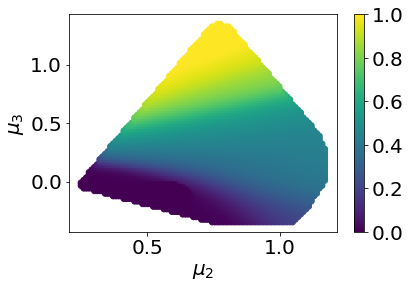

In [21]:
test_pts = torch.tensor(new_grid,dtype=torch.float32)
torch.save(test_pts,'test_pts_beta5.pt')
chia,chib = chiAB(test_pts)
q_tilde = model(test_pts)
Q = q_theta(test_pts,chia,chib,q_tilde)
plt.scatter(new_grid[:,0],new_grid[:,1],c = Q.detach().numpy())
plt.xlabel('$\mu_2$')
plt.ylabel('$\mu_3$')
# plt.rcParams.update({'font.size': 20})
plt.colorbar()